
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Search <br>


____

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from queue import Queue, LifoQueue, PriorityQueue
import random


# Uninformed & Informed Search

## Problem Definition

In This Problem, We want to investigate Maze Problem with the focus on implementing BFS,DFS and A-Star algorithm to solve it. This notebook is inspired by the [pacman](https://freepacman.org/) game. We generate a random maze and put the pacman in the top left crner and the food in the bottom right corner. The goal is to find a way from the pacman to the food using different search algorithms.



## Code

In [2]:
def generate_maze(rows, cols, wall_prob=0.3):
    np.random.seed(40)
    maze = np.random.choice([0, 1], size=(rows, cols), p=[1-wall_prob, wall_prob])
    start = (0, 0)
    goal = (rows-1, cols-1)
    maze[start] = 0
    maze[goal] = 0
    return maze, start, goal

def plot_maze(maze, path=None, start=None, goal=None):
    plt.imshow(maze, cmap="gray")
    if path:
        x, y = zip(*path)
        plt.plot(y, x, color='yellow', linewidth=2)  # Plot path in yellow
    if start:
        plt.scatter(start[1], start[0], color='blue', s=100, label='Pacman')  # Pacman start
    if goal:
        plt.scatter(goal[1], goal[0], color='green', s=100, label='Food')  # Food
    plt.legend()
    plt.show()

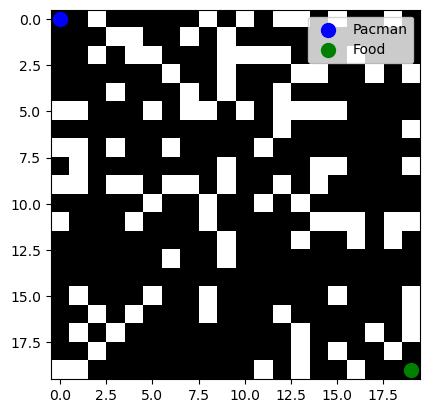

In [3]:
rows, cols = 20, 20
maze, start, goal = generate_maze(rows, cols)
plot_maze(maze, start=start, goal=goal)


In [4]:
class SearchAlgorithm:
    def __init__(self, maze):
        self.maze = maze
        self.rows, self.cols = maze.shape
        self.visited = np.zeros_like(maze)
        self.expanded_nodes = 0

    def get_neighbors(self, pos):
        neighbors = []
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up
        for d in directions:
            new_pos = (pos[0] + d[0], pos[1] + d[1])
            if 0 <= new_pos[0] < self.rows and 0 <= new_pos[1] < self.cols and not self.maze[new_pos] and not self.visited[new_pos]:
                neighbors.append(new_pos)
        return neighbors


In [5]:
def plot_algorithm(maze, start, goal,name,algorithm):
  path = algorithm.search(start, goal)
  result = {'path': path, 'expanded_nodes': algorithm.expanded_nodes}
  print(f"{name}: Expanded Nodes = {algorithm.expanded_nodes}")
  plot_maze(maze, path, start, goal)



In [6]:
class DFS(SearchAlgorithm):
    
    def __init__(self, maze):
        super().__init__(maze)
        self.path = []

    def search(self, start, goal):
        self._visit_node(start)
        

        if self._is_goal(start, goal):
            return self.path

        neighbors = self.get_neighbors(start)
        self.expanded_nodes += len(neighbors)
        
        if not neighbors:
            self._backtrack()
            return None

        for neighbor in neighbors:
            if not self._is_visited(neighbor):
                result = self.search(neighbor, goal)
                if result: #If path to goal is found = result is not null
                    return result

        self._backtrack()
        return None

    def _visit_node(self, node):
        self.path.append(node)
        self.visited[node] = 1

    def _is_goal(self, node, goal):
        return node == goal

    def _is_visited(self, node):
        return self.visited[node] == 1

    def _backtrack(self):
        self.path.pop()
        

DFS: Expanded Nodes = 104


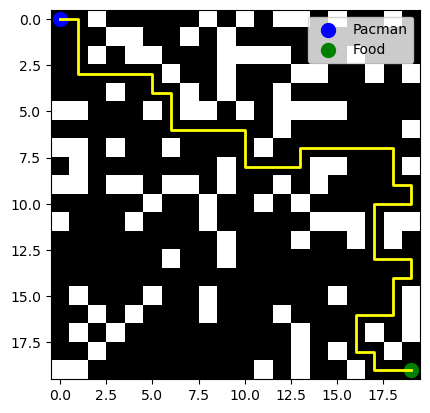

In [7]:
plot_algorithm(maze,start,goal,'DFS', DFS(maze))

In [8]:
from collections import deque

class BFS(SearchAlgorithm):

    def __init__(self, maze):
        super().__init__(maze)
        self.parent = {}  # Dictionary to store parents
        self.path = []

    
    def search(self, start, goal):
        self.fringe = deque([start])  
        self._visit_node(start)  
        self.parent[start] = None  

        while self.fringe:
            current_node = self.fringe.popleft()  # Dequeue node

            if self._is_goal(current_node, goal):
                return self._reconstruct_path(goal)  

            neighbors = self.get_neighbors(current_node)
            self.expanded_nodes += len(neighbors)

            for neighbor in neighbors:
                if not self._is_visited(neighbor):
                    self.fringe.append(neighbor)  # Enqueue neighbors
                    self._visit_node(neighbor) 
                    self.parent[neighbor] = current_node  

        return None  
    
    def _visit_node(self, node):
        self.visited[node] = 1
       

    def _is_goal(self, node, goal):
        return node == goal

    def _is_visited(self, node):
        return self.visited[node] == 1
    
    def _reconstruct_path(self, goal):
        node = goal
        while node is not None:  
            self.path.append(node)
            node = self.parent[node]
        self.path.reverse()  
        return self.path


BFS: Expanded Nodes = 279


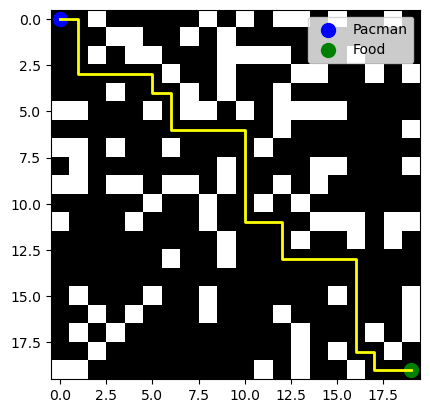

In [9]:
plot_algorithm(maze,start,goal,'BFS', BFS(maze))

Advantages and Disadvantages of each method in the context of the Maze Problem

In the maze problem DFS uses less memory and can find a solution quickly by expanding fewer nodes if the goal is far from the start, but it doesn’t always give the shortest path and can get stuck. On the other hand BFS always finds the shortest path and explores every possible option, but it uses more memory and expands many more nodes, which can make it slower if the goal is deep in the maze. DFS is better when memory is limited, while BFS is better when finding the shortest path is important, even if it takes more time and memory.

In [10]:
import heapq

class AStar(SearchAlgorithm):
    
    def heuristic(self, current, goal):
        return abs(current[0] - goal[0]) + abs(current[1] - goal[1])

    def search(self, start, goal):
        priority_queue = []
        heapq.heappush(priority_queue, (self.heuristic(start, goal), start, 0))

        g_cost = {start: 0}
        came_from = {start: None}
        
        while priority_queue:
            _, current_node, current_g_cost = heapq.heappop(priority_queue)

            if current_node == goal:
                return self._build_path(came_from, current_node)
            
            self.expanded_nodes += 1
            self.visited[current_node] = 1
            
            for neighbor in self.get_neighbors(current_node):
                new_g_cost = current_g_cost + 1
                
                if neighbor not in g_cost or new_g_cost < g_cost[neighbor]:
                    g_cost[neighbor] = new_g_cost
                    f_cost = new_g_cost + self.heuristic(neighbor, goal)
                    heapq.heappush(priority_queue, (f_cost, neighbor, new_g_cost))
                    came_from[neighbor] = current_node

        return None
    
    def _build_path(self, came_from, current_node):
        path = []
        while current_node:
            path.append(current_node)
            current_node = came_from[current_node]
        path.reverse()
        return path


A*: Expanded Nodes = 168


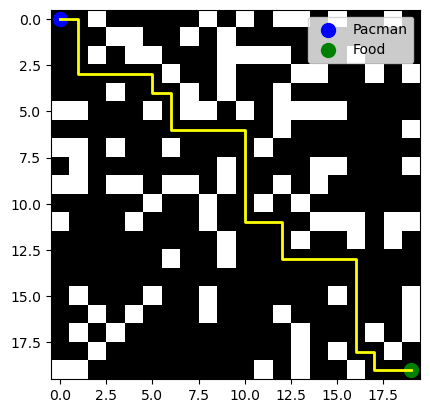

In [11]:
plot_algorithm(maze,start,goal,'A*', AStar(maze))

A* is a better way to solve mazes because it uses a smart guess (heuristic) to focus on the best paths and keeps track of the steps taken. This helps it find the shortest path quickly by avoiding unnecessary areas. Other methods like BFS and DFS look at too many wrong paths. BFS finds the shortest path but is slower, and DFS might not find the best path at all. A* is faster and more effective for solving mazes.

Now we want to explore a situation where each cell of the maze has an entrance cost, which means in order to enter that cell we must pay a fixed price. 

In [12]:
def generate_maze_with_costs(rows, cols, wall_prob=0.3):
    np.random.seed(137)
    maze = np.random.choice([0, 1], size=(rows, cols), p=[1-wall_prob, wall_prob])
    costs = np.random.randint(1, 11, size=(rows, cols))
    start = (0, 0)
    goal = (rows-1, cols-1)
    maze[start] = 0
    maze[goal] = 0
    return maze, costs, start, goal

def plot_maze_with_costs(maze, costs, path=None, start=None, goal=None):
    plt.imshow(maze, cmap="gray", vmin=0, vmax=1)

    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i, j] == 0:
                cl = 'red' if costs[i,j] > 6 else ('green' if costs[i,j] < 4 else 'orange')
                plt.text(j, i, str(costs[i, j]), ha='center', va='center', color=cl, fontsize=8)

    if path:
        x, y = zip(*path)
        plt.plot(y, x, color='yellow', linewidth=2)  # Plot path in yellow
    if start:
        plt.scatter(start[1], start[0], color='blue', s=100, label='Pacman')  # Pacman start
    if goal:
        plt.scatter(goal[1], goal[0], color='pink', s=100, label='Food')  # Food
    plt.legend()
    plt.show()


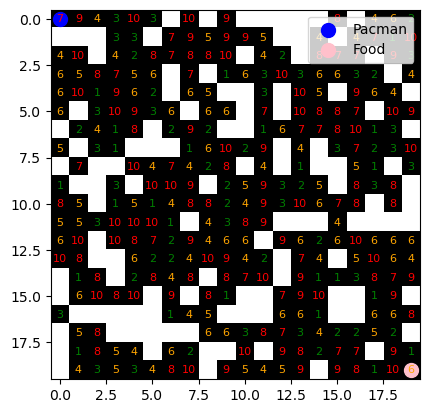

In [13]:
rows, cols = 20, 20
maze, costs, start, goal = generate_maze_with_costs(rows, cols)
plot_maze_with_costs(maze, costs, start=start, goal=goal)

In [14]:
# Search Algorithms
class SearchAlgorithmWithCosts:
    def __init__(self, maze, costs):
        self.maze = maze
        self.costs = costs
        self.rows, self.cols = maze.shape
        self.visited = np.zeros_like(maze)
        self.expanded_nodes = 0

    def get_neighbors(self, pos):
        neighbors = []
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up
        for d in directions:
            new_pos = (pos[0] + d[0], pos[1] + d[1])
            if 0 <= new_pos[0] < self.rows and 0 <= new_pos[1] < self.cols and not self.maze[new_pos] and not self.visited[new_pos]:
                neighbors.append(new_pos)
        return neighbors

    def calculate_total_cost(self, path):
        return sum(self.costs[pos] for pos in path)



In [15]:
def plot_algorithms_with_costs(maze, costs, start, goal,name,algorithm):
    path, total_cost = algorithm.search(start, goal)
    result = {'path': path, 'expanded_nodes': algorithm.expanded_nodes, 'total_cost': total_cost}
    print(f"{name}: Expanded Nodes = {algorithm.expanded_nodes}, Total Cost = {total_cost}")
    plot_maze_with_costs(maze, costs, path, start, goal)


In [16]:
# DFS Algorithm with Costs
class DFSWithCosts(SearchAlgorithmWithCosts):
    def __init__(self,maze,costs):
        super().__init__(maze,costs)
        
    def search(self, start, goal):
        algorithm = DFS(maze)
        best_path = algorithm.search(start,goal)
        self.expanded_nodes = algorithm.expanded_nodes
        best_cost = 0
        for node in best_path:
            best_cost += self.costs[node]

        return best_path, best_cost

DFS: Expanded Nodes = 90, Total Cost = 265


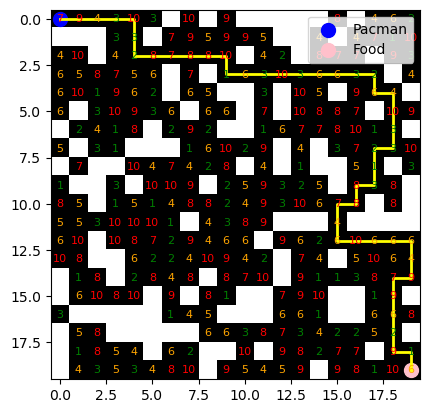

In [17]:
plot_algorithms_with_costs(maze, costs, start, goal,'DFS',DFSWithCosts(maze,costs))

In [18]:
# BFS Algorithm with Costs
class BFSWithCosts(SearchAlgorithmWithCosts):
    def search(self, start, goal):
        algorithm = BFS(maze)
        best_path = algorithm.search(start,goal)
        self.expanded_nodes = algorithm.expanded_nodes
        best_cost = 0
        for node in best_path:
            best_cost += self.costs[node]

        return best_path, best_cost


BFS: Expanded Nodes = 267, Total Cost = 232


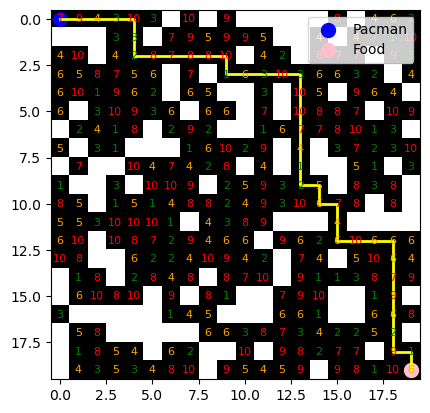

In [19]:
plot_algorithms_with_costs(maze, costs, start, goal,'BFS',BFSWithCosts(maze,costs))

In [20]:
# A* Algorithm with Costs
class AStarWithCosts(SearchAlgorithmWithCosts):
    def heuristic(self, pos, goal):
        return

    def search(self, start, goal):
        algorithm = AStar(maze)
        best_path = algorithm.search(start,goal)
        self.expanded_nodes = algorithm.expanded_nodes
        best_cost = 0
        for node in best_path:
            best_cost += self.costs[node]

        return best_path, best_cost


A*: Expanded Nodes = 145, Total Cost = 232


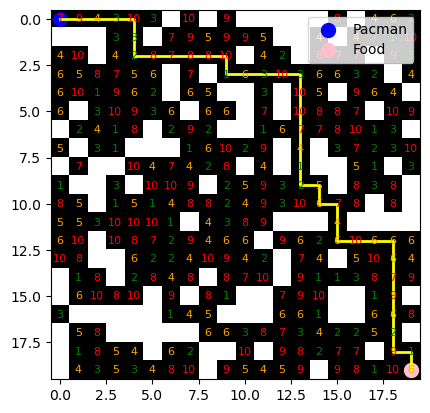

In [21]:
plot_algorithms_with_costs(maze, costs, start, goal,'A*',AStarWithCosts(maze,costs))

Advantages and Disadvantages of each method in the context of the Maze Problem

DFS is fast but doesn’t always find the shortest path and can get stuck in dead ends. BFS always finds the shortest path but takes longer and uses a lot of memory because it looks at many unnecessary paths. A* is the best of both—it's smart about which paths to check, finds the shortest path quickly, and avoids wasting time, but it also uses a lot of memory like BFS. Overall, A* is the most efficient for solving mazes, while DFS is fast but unreliable, and BFS is slow but guaranteed to work.